In [1]:
from ptgnn.dataset import RSDataset

In [ ]:
rs = RSDataset(split='val')

In [61]:
import pandas as pd
from ptgnn.dataset.utils_chienn import get_chiro_data_from_mol
from ptgnn.features.chienn.molecule3d import smiles_to_3d_mol

In [9]:
df = pd.read_pickle("src/rs/raw/train.pickle")

In [10]:
display(df)

,ID,SMILES_nostereo,rdkit_mol_cistrans_stereo,RS_label,RS_label_binary
0,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x000001EBC21...,S,1
1,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x000001EBC21...,S,1
2,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x000001EBC21...,S,1
3,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x000001EBC21...,S,1
4,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x000001EBC21...,S,1
...,...,...,...,...,...
326860,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x000001EC89A...,R,0
326861,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x000001EC89A...,R,0
326862,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x000001EC89A...,R,0
326863,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x000001EC89A...,R,0


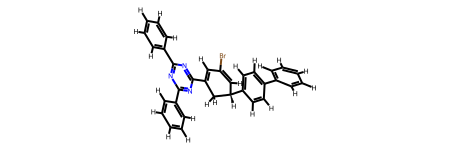

In [62]:
# mol_example = df.rdkit_mol_cistrans_stereo.iloc[6]# 0
mol_example = smiles_to_3d_mol(
    df.ID.iloc[6],
    max_number_of_attempts=100,
    max_number_of_atoms=100
)
display(mol_example)

In [63]:
data = get_chiro_data_from_mol(mol_example)
display(data)

Data(x=[61, 52], edge_index=[2, 132], edge_attr=[132, 14], pos=[61, 3], bond_distances=[66], bond_distance_index=[2, 66], bond_angles=[108], bond_angle_index=[3, 108], dihedral_angles=[163], dihedral_angle_index=[4, 163])

In [64]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [65]:
# determine stereocenters
AllChem.FindMolChiralCenters(mol_example)

[(3, 'R')]

In [69]:
for a, b in data.edge_index.T:
    if a == 3 or b == 3:
        print(a,b)

tensor(2) tensor(3)
tensor(3) tensor(2)
tensor(3) tensor(4)
tensor(4) tensor(3)
tensor(3) tensor(16)
tensor(16) tensor(3)
tensor(3) tensor(38)
tensor(38) tensor(3)


In [70]:
for bond in mol_example.GetBonds():
    if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
        print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())
        print(bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx())

Bond 1 stereo: STEREONONE
1 2
Bond 35 stereo: STEREONONE
17 36


In [72]:
data.edge_index ==

False

In [57]:
type(mol_example)

rdkit.Chem.rdchem.Mol

In [74]:
display(Chem.GetAdjacencyMatrix(mol_example))

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

## own version of to_edge_graph

In [10]:
import torch
import torch_geometric
from ptgnn.dataset.utils_chienn import get_chiro_data_from_mol
from ptgnn.features.chienn.molecule3d import smiles_to_3d_mol
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

### Fetch input for function

In [2]:
df = pd.read_pickle("src/rs/raw/train.pickle")

In [4]:
display(df)

,ID,SMILES_nostereo,rdkit_mol_cistrans_stereo,RS_label,RS_label_binary
0,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000024FE4D...,S,1
1,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000024FE4D...,S,1
2,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000024FE4D...,S,1
3,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000024FE4D...,S,1
4,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x0000024FE4D...,S,1
...,...,...,...,...,...
326860,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025098C...,R,0
326861,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025098C...,R,0
326862,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025098C...,R,0
326863,c1nnc([C@H]2CNCCO2)n1C1CC1,c1nnc(C2CNCCO2)n1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x0000025098C...,R,0


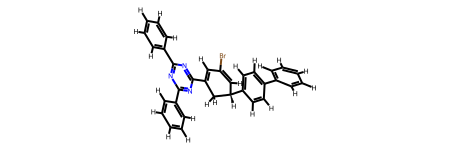

In [42]:
# mol_example = df.rdkit_mol_cistrans_stereo.iloc[6]# 0
mol_example = smiles_to_3d_mol(
    df.ID.iloc[6],
    max_number_of_attempts=100,
    max_number_of_atoms=100
)
display(mol_example)

In [43]:
data = get_chiro_data_from_mol(mol_example)
display(data)

Data(x=[61, 52], edge_index=[2, 132], edge_attr=[132, 14], pos=[61, 3], bond_distances=[66], bond_distance_index=[2, 66], bond_angles=[108], bond_angle_index=[3, 108], dihedral_angles=[163], dihedral_angle_index=[4, 163])

### Do chemical transformation and information gathering

In [44]:
# make sure it is undirected
if not torch_geometric.utils.is_undirected(data.edge_index):
    edge_index, edge_attr = torch_geometric.utils.to_undirected(edge_index=data.edge_index, edge_attr=data.edge_attr)
else:
    edge_index, edge_attr = data.edge_index, data.edge_attr

In [45]:
# get chiralic centers
chiral_centers = Chem.FindMolChiralCenters(mol_example, includeUnassigned=True)
display(chiral_centers)

[(3, 'R')]

In [46]:
# Using GetStereo()
for b in mol_example.GetBonds():
    print(b.GetBeginAtomIdx(),b.GetEndAtomIdx(),
          b.GetBondType(),b.GetStereo())

0 1 SINGLE STEREONONE
1 2 DOUBLE STEREONONE
2 3 SINGLE STEREONONE
3 4 SINGLE STEREONONE
4 5 AROMATIC STEREONONE
5 6 AROMATIC STEREONONE
6 7 AROMATIC STEREONONE
7 8 SINGLE STEREONONE
8 9 AROMATIC STEREONONE
9 10 AROMATIC STEREONONE
10 11 AROMATIC STEREONONE
11 12 AROMATIC STEREONONE
12 13 AROMATIC STEREONONE
7 14 AROMATIC STEREONONE
14 15 AROMATIC STEREONONE
3 16 SINGLE STEREONONE
16 17 SINGLE STEREONONE
17 18 SINGLE STEREONONE
18 19 AROMATIC STEREONONE
19 20 AROMATIC STEREONONE
20 21 SINGLE STEREONONE
21 22 AROMATIC STEREONONE
22 23 AROMATIC STEREONONE
23 24 AROMATIC STEREONONE
24 25 AROMATIC STEREONONE
25 26 AROMATIC STEREONONE
20 27 AROMATIC STEREONONE
27 28 AROMATIC STEREONONE
28 29 SINGLE STEREONONE
29 30 AROMATIC STEREONONE
30 31 AROMATIC STEREONONE
31 32 AROMATIC STEREONONE
32 33 AROMATIC STEREONONE
33 34 AROMATIC STEREONONE
28 35 AROMATIC STEREONONE
17 36 DOUBLE STEREONONE
36 1 SINGLE STEREONONE
15 4 AROMATIC STEREONONE
35 18 AROMATIC STEREONONE
13 8 AROMATIC STEREONONE
26 21 AR

In [47]:
for element in Chem.FindPotentialStereo(mol_example):
    print(f"Type: {element.type}, which: {element.centeredOn}, specified: {element.specified}, descriptor: {element.descriptor}, controllingAtoms: {element.controllingAtoms}, permutation: {element.permutation}")

Type: Atom_Tetrahedral, which: 3, specified: Specified, descriptor: Tet_CCW, controllingAtoms: <rdkit.rdBase._vectunsigned int object at 0x0000024FC4F8ED60>, permutation: 0


In [57]:
rings = mol_example.GetRingInfo()

for ring in rings.AtomRings():
    print(ring)

(13, 12, 11, 10, 9, 8)
(15, 14, 7, 6, 5, 4)
(26, 25, 24, 23, 22, 21)
(34, 33, 32, 31, 30, 29)
(35, 28, 27, 20, 19, 18)
(36, 17, 16, 3, 2, 1)


In [59]:
rings = mol_example.GetRingInfo()

for ring in rings.BondRings():
    print(ring)

(12, 11, 10, 9, 8, 39)
(14, 13, 6, 5, 4, 37)
(25, 24, 23, 22, 21, 40)
(33, 32, 31, 30, 29, 41)
(34, 27, 26, 19, 18, 38)
(35, 16, 15, 2, 1, 36)


In [ ]:
# transformation to edges and keep track of indices aka how to map index of current center to edge/new nodes

In [ ]:
# so... different modes
# 1: normally C but do something special for stereocenters aka Z (chienn but sometimes allow more stereoisomers)
# 2: not two nodes for each edge but make more complex permutation tree with P(Z,Z) or P(C,C)
# 3: enantiomer: on double edge (or specific stereo candidate) fuze two edges not to P(Z,Z), but make Z/C(1,2,3,4)
# 4: ext of 3: do so for normal edges too in case of rotamer. ==> catch condition that atoms not on one axis
# 5:      or: map both sides at once and if equal mapped then Z(P, P, P)